In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [4]:
df = pd.DataFrame(pd.read_csv(r'catalogue_out.csv'))
print(df)

    Unnamed: 0    zb_dl  zb_true_dl      dlb_dl   dlberr_dl
0            0  0.12125     0.12052   581.51438   10.472995
1            1  0.21121     0.21044  1074.33456   12.967163
2            2  0.37076     0.37055  2053.61703   64.216697
3            3  0.25726     0.25884  1367.00135   66.805290
4            4  0.09996     0.09821   478.33361   60.393946
..         ...      ...         ...         ...         ...
90          90  0.25659     0.25687  1367.00135  126.242450
91          91  0.09263     0.09014   427.64956   12.474550
92          92  0.12901     0.12979   633.99673   61.574080
93          93  0.23043     0.23075  1189.85641   47.154152
94          94  0.32962     0.33014  1797.47822   35.536180

[95 rows x 5 columns]


In [5]:
df.sort_values(["zb_dl"],axis=0, ascending=True,inplace=True,na_position='first')
print(df)

    Unnamed: 0    zb_dl  zb_true_dl      dlb_dl   dlberr_dl
30          30  0.00896     0.00981    44.89369    1.083196
38          38  0.04918     0.05000   231.12517    2.651061
21          21  0.06009     0.06003   279.30983   11.529917
27          27  0.08914     0.08840   427.64956   41.251119
91          91  0.09263     0.09014   427.64956   12.474550
..         ...      ...         ...         ...         ...
25          25  0.36800     0.37174  2053.61703  119.397467
2            2  0.37076     0.37055  2053.61703   64.216697
71          71  0.37119     0.36623  2053.61703  169.444186
28          28  0.37878     0.37927  2118.74751   86.423812
88          88  0.38868     0.38863  2184.30519   66.599612

[95 rows x 5 columns]


In [18]:
data_z_err = df['zb_dl'].to_numpy()
data_z = df['zb_true_dl'].to_numpy()
data_dl = df['dlb_dl'].to_numpy()
delta_dl = df['dlberr_dl'].to_numpy()

delta_z = np.absolute(data_z - data_z_err)

Text(0.5, 0, '$z$')

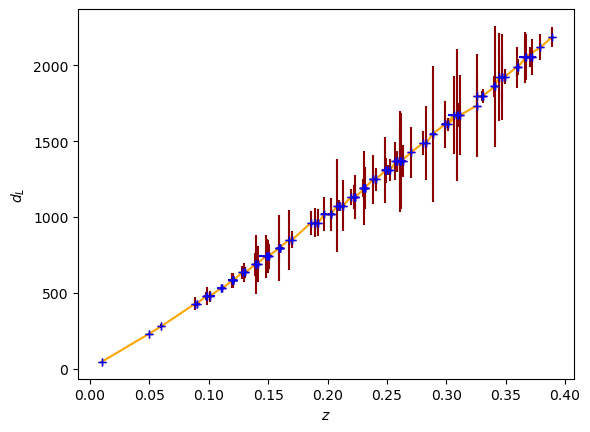

In [19]:
plt.plot(data_z,data_dl, color="orange")
plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.errorbar(data_z, data_dl, xerr=delta_z,fmt ='+', color="blue")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

In [20]:
N_obs = len(data_z)

In [21]:
# Define the dimensionality of our problem.
ndim = 3

#[]{}
            
def loglike(x):
    """The log-likelihood function."""    
    c = 3e5
    H0, q0, j0 = x
    
    model_dl = ((c*data_z)/H0)*(1+0.5*(1 - q0)*data_z-(1/6)*(1 - q0 - 3*q0**2 + j0)*data_z**2)
    
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - model_dl)**2)
                          
    return(first_term + second_term)


# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

#    return 100. * (2. * u - 1.)
    hprime, qprime, jprime = u
    
#    h = 100. * (hprime)
#    q = 10. * (2. * qprime - 1.)
#    j = 10. * (2. * jprime - 1.)
    hmin = 0.
    hmax = 100.0

    qmin = -10.0
    qmax = 10.0

    jmin = -10.0
    jmax = 10.0
    
    
    h = hprime * (hmax - hmin) + hmin
    q = qprime * (qmax - qmin) + qmin
    j = jprime * (jmax - jmin) + jmin
    
    return(h, q, j)    

In [22]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim, nlive=1500)
sampler.run_nested()
sresults = sampler.results

15306it [00:09, 1614.17it/s, +1500 | bound: 15 | nc: 1 | ncall: 87041 | eff(%): 19.647 | loglstar:   -inf < -497.253 <    inf | logz: -507.776 +/-  0.091 | dlogz:  0.001 >  1.509]


In [23]:
# "Dynamic" nested sampling.
dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

16961it [00:11, 1541.23it/s, batch: 7 | bound: 6 | nc: 1 | ncall: 59813 | eff(%): 28.133 | loglstar: -502.639 < -497.257 < -498.157 | logz: -507.918 +/-  0.083 | stop:  0.858]        


In [24]:
# Combine results from "Static" and "Dynamic" runs.
results = dyfunc.merge_runs([sresults, dresults])

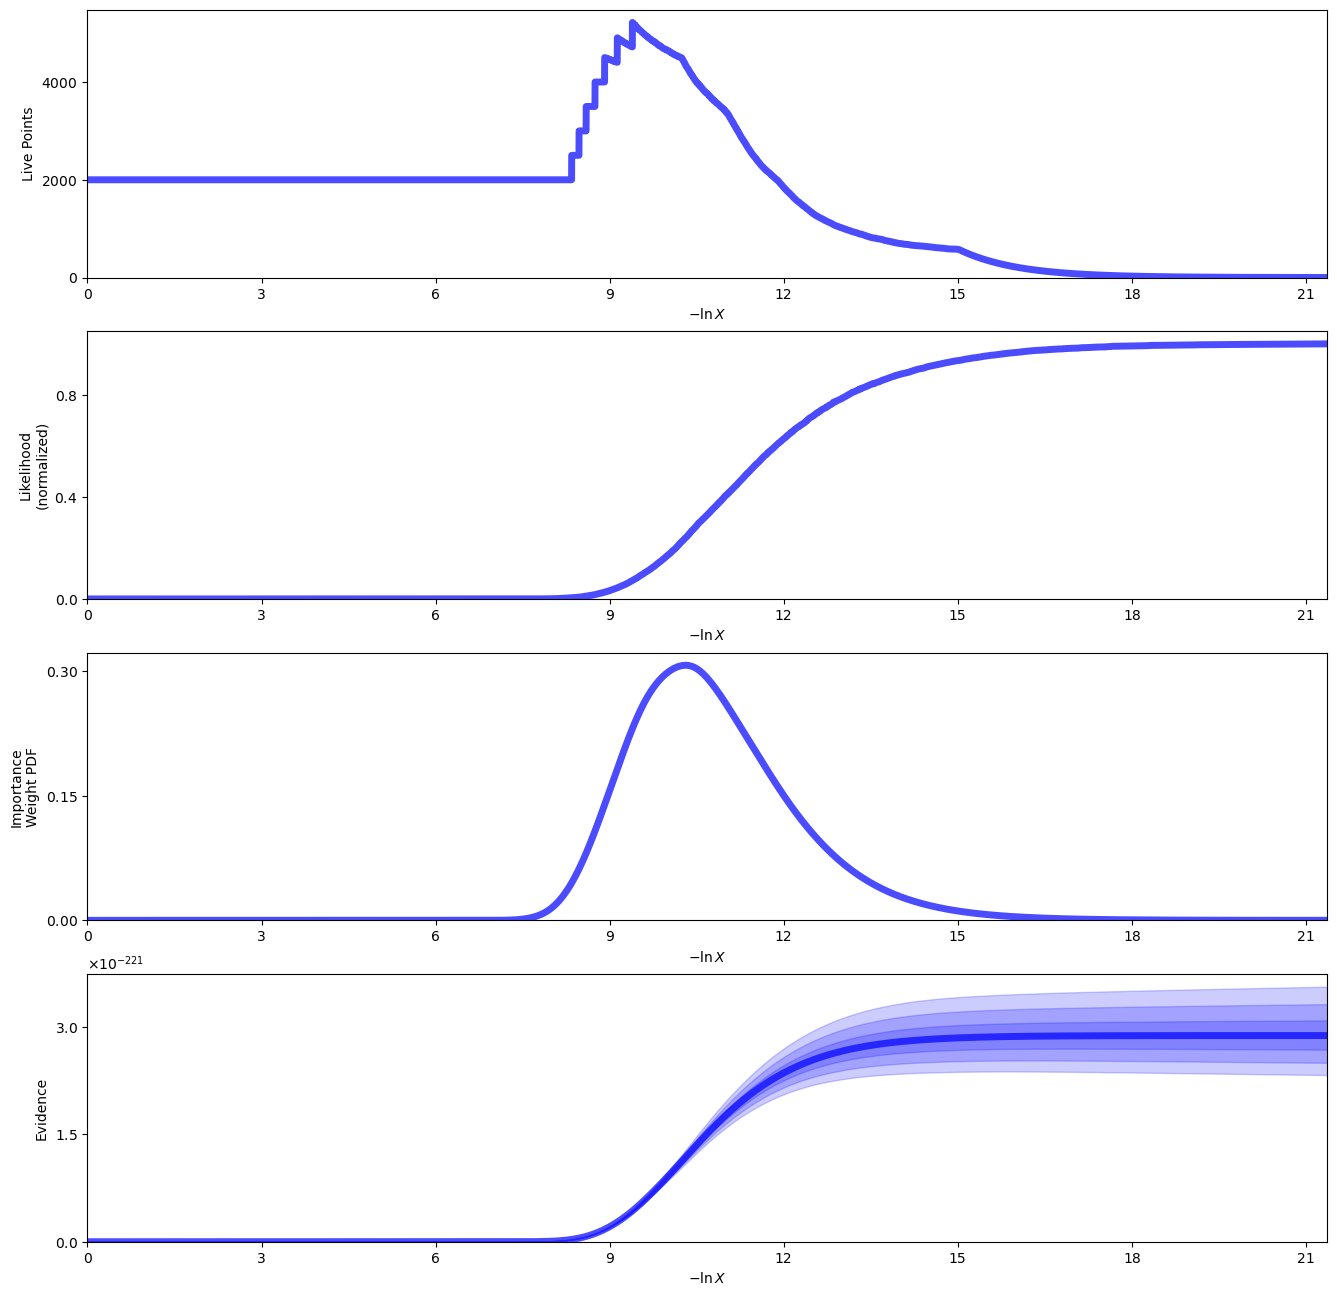

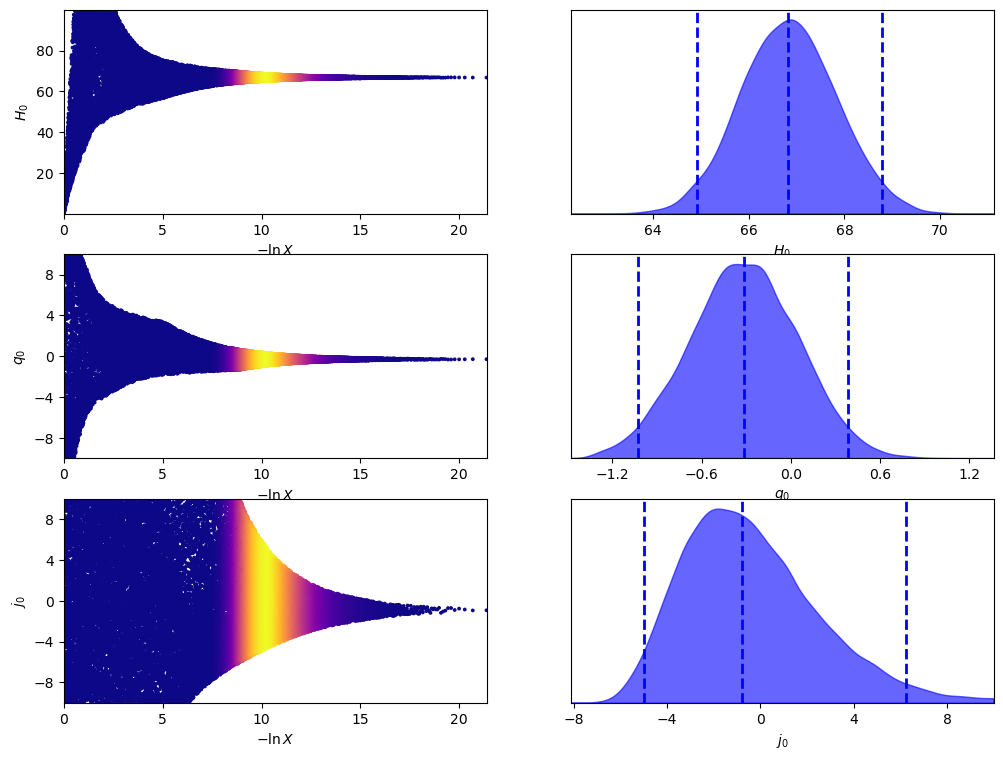

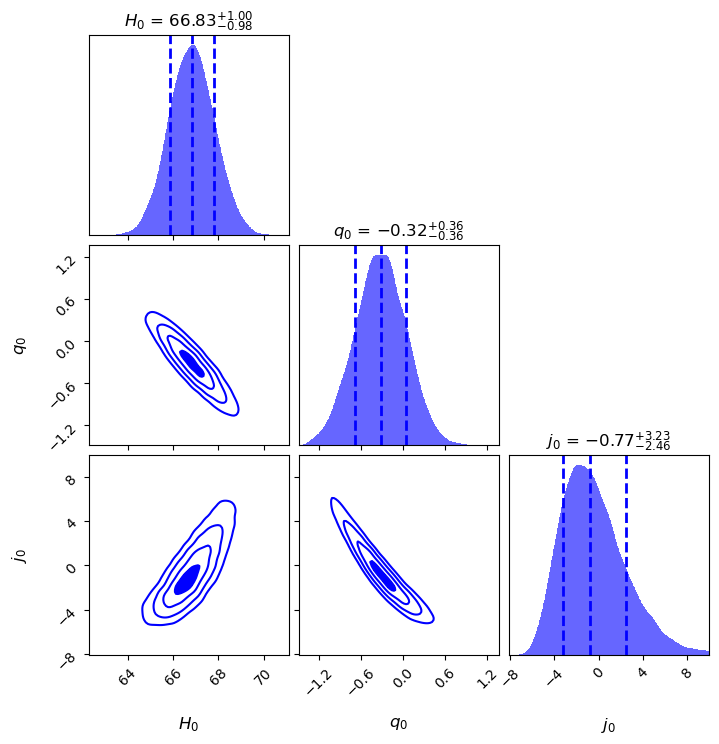

In [40]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results, labels=[r"$H_0$", r"$q_0$", r"$j_0$"])

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results, color = 'blue', labels=[r"$H_0$", r"$q_0$", r"$j_0$"], show_titles=True, label_kwargs = {"fontsize":12}, 
                                quantiles=[0.16, 0.5, 0.84], title_quantiles=[0.16, 0.5, 0.84], title_fmt='.2f', title_kwargs={"fontsize": 12})

#color='dodgerblue', truths=np.zeros(ndim),
#                           truth_color='black', show_titles=True,
#                           quantiles=None, max_n_ticks=3,
#                           fig=(fig, axes[:, 4:]))
#figure = corner.corner(samples, bins = 30, color = 'purple', labels = params, 
#                plot_datapoints = False, smooth1d = True, smooth = True, quantiles=[0.16, 0.5, 0.84],
#                show_titles = True, label_kwargs = {"fontsize":12}, title_fmt='.2f',title_kwargs={"fontsize": 12})